**Objective** : The main purpose behind this lab is to get familiar with Pytorch library to do
Classification and Regression tasks by establishing DNN/MLP architectures.

# **Part one regression:**

### **1. Apply the Exploratory data analysis technics to understand and visualize the given Dataset.**

In [5]:
!pip install pandas matplotlib seaborn

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159108 entries, 0 to 159107
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    159108 non-null  object 
 1   symbol  159108 non-null  object 
 2   open    159108 non-null  float64
 3   close   159108 non-null  float64
 4   low     159108 non-null  float64
 5   high    159108 non-null  float64
 6   volume  159108 non-null  float64
dtypes: float64(5), object(2)
memory usage: 8.5+ MB
None

First few rows of the dataset:
                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  11

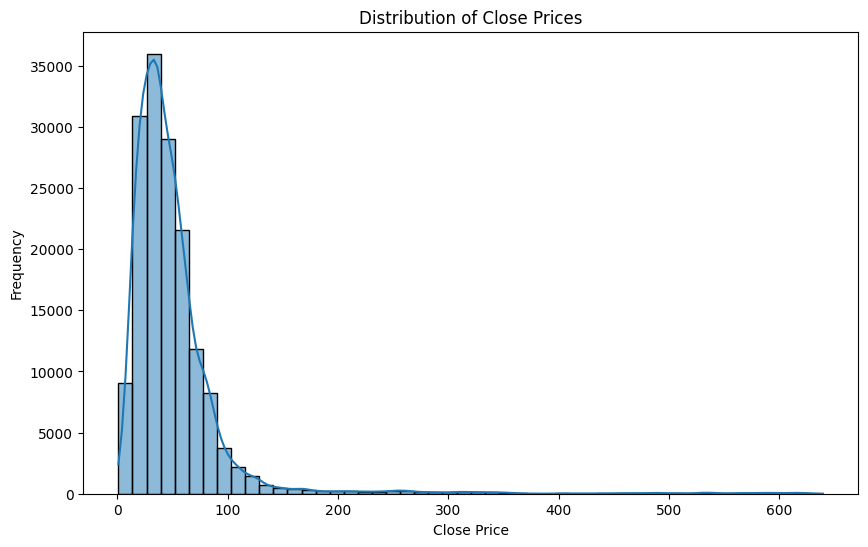

<ipython-input-9-300d1d78b676>:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')


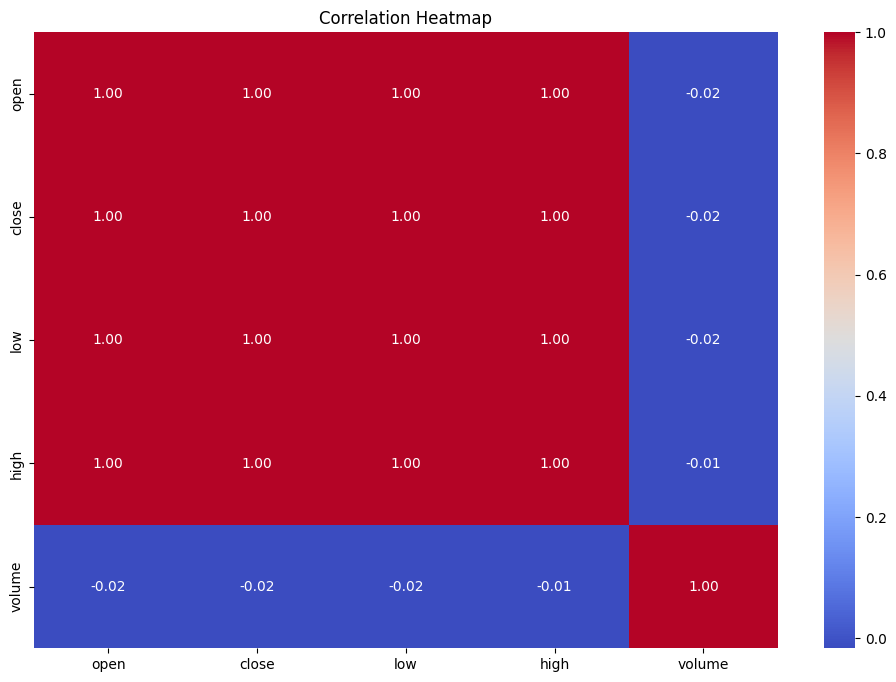

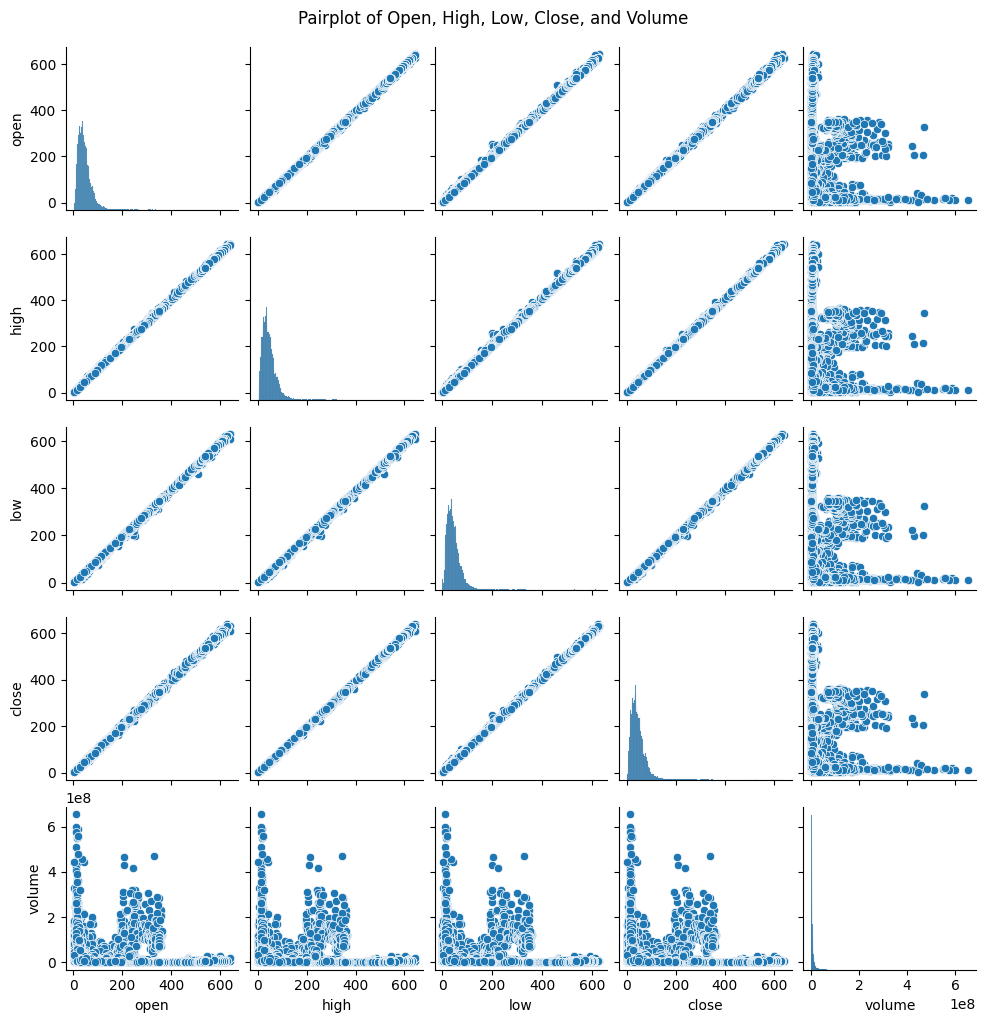

In [9]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("prices.csv")

# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(df.head())

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Visualize distribution of a specific column (e.g., 'Close')
plt.figure(figsize=(10, 6))
sns.histplot(df['close'], bins=50, kde=True)
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Pairplot for selected columns
sns.pairplot(df[['open', 'high', 'low', 'close', 'volume']], height=2)
plt.suptitle('Pairplot of Open, High, Low, Close, and Volume', y=1.02)
plt.show()


### **2. Establish a Deep Neural network Architecture by using PyTorch library to handle the regression task.**

In [30]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Convert the DataFrame to PyTorch tensors
features = df[['open', 'high', 'low', 'volume']].values
target = df['close'].values.reshape(-1, 1)  # Assuming 'close' is the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the Deep Neural Network (DNN) architecture
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_train.shape[1]
model = RegressionModel(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    mse = mean_squared_error(y_test, y_pred.numpy())
    print(f'Mean Squared Error on Test Set: {mse:.4f}')


Epoch [10/50], Loss: 5167.1704
Epoch [20/50], Loss: 5124.0840
Epoch [30/50], Loss: 5064.9600
Epoch [40/50], Loss: 4982.2192
Epoch [50/50], Loss: 4868.9438
Mean Squared Error on Test Set: 4817.2035


In [34]:
# Import necessary libraries
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Create a PyTorch model wrapper for sklearn
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, hidden_size1=10, hidden_size2=10, lr=0.001, epochs=10):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.lr = lr
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        self.model = RegressionModel(self.input_size, self.hidden_size1, self.hidden_size2)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        for epoch in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

        return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy()

# Define the parameter grid for GridSearch
param_grid = {
    'hidden_size1': [10, 10],
    'hidden_size2': [10, 10],
    'lr': [0.001, 0.01],
    'epochs': [10, 10]
}

# Create an instance of the PyTorchRegressor
pytorch_model = PyTorchRegressor(input_size=4)

# Wrap the PyTorch model with sklearn's GridSearchCV
grid_search = GridSearchCV(pytorch_model, param_grid, scoring=make_scorer(mean_squared_error), cv=3)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse:.4f}')


Best Hyperparameters: {'epochs': 10, 'hidden_size1': 10, 'hidden_size2': 10, 'lr': 0.001}
Mean Squared Error on Test Set: 5128.4866


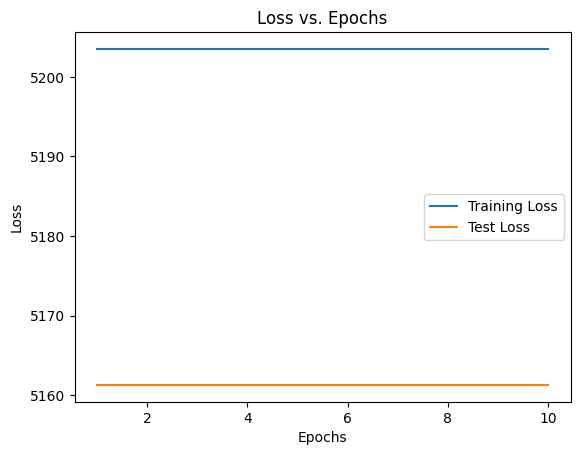

In [35]:
import matplotlib.pyplot as plt

# Define the PyTorch model with the best hyperparameters
best_model = PyTorchRegressor(input_size=4, hidden_size1=10, hidden_size2=10, lr=0.001, epochs=10)

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Get the loss for both training and test sets
train_losses = []
test_losses = []

for epoch in range(10):
    optimizer.zero_grad()
    outputs = best_model.model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        test_outputs = best_model.model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

# Plot the loss graph
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [42]:
import torch.nn.functional as F


# Modify the PyTorchRegressor class to accept the PyTorch model directly
class PyTorchRegressor(nn.Module):
    def __init__(self, model, lr=0.001, epochs=50):
        super(PyTorchRegressor, self).__init__()
        self.model = model
        self.lr = lr
        self.epochs = epochs

    def forward(self, x):
        return self.model(x)

    def fit(self, X, y):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        for epoch in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

        return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.numpy()

# Define the RegularizedRegressionModel with Dropout
class RegularizedRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_rate=0.5):
        super(RegularizedRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Create an instance of the PyTorchRegressor with the RegularizedRegressionModel
regularized_model = PyTorchRegressor(
    model=RegularizedRegressionModel(input_size=4, hidden_size1=10, hidden_size2=10, dropout_rate=0.5),
    lr=0.001,
    epochs=10
)

# Train the regularized model
regularized_model.fit(X_train, y_train)

# Evaluate the regularized model on the test set
y_pred_regularized = regularized_model.predict(X_test)
mse_regularized = mean_squared_error(y_test, y_pred_regularized)
print(f'Mean Squared Error with Regularization: {mse_regularized:.4f}')

# Compare the results
print(f'Mean Squared Error without Regularization: {mse:.4f}')
print(f'Mean Squared Error with Regularization: {mse_regularized:.4f}')




Mean Squared Error with Regularization: 5080.7315
Mean Squared Error without Regularization: 5128.4866
Mean Squared Error with Regularization: 5080.7315
